# Data analysis with ROOT in Python

TODO

In [1]:
import ROOT

Welcome to JupyROOT 6.23/01


## Create a dataframe from a ROOT dataset, read remotely

TODO, remote data, multithreading

In [2]:
path = 'root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root'
df = ROOT.RDataFrame('Events', path)

## Select events with two muons and opposite charge

TODO, note that we reduce the example from 66 mio to 100k

In [3]:
df = df.Filter("nMuon == 2", "Events with exactly two muons")\
       .Filter("Muon_charge[0] != Muon_charge[1]", "Muons with opposite charge")\
       .Range(100000)

## Compute the invariant mass

In [4]:
ROOT.gInterpreter.Declare(
"""
using Vec_t = const ROOT::VecOps::RVec<float>&;
float compute_mass(Vec_t pt, Vec_t eta, Vec_t phi, Vec_t mass) {
    ROOT::Math::PtEtaPhiMVector p1(pt[0], eta[0], phi[0], mass[0]);
    ROOT::Math::PtEtaPhiMVector p2(pt[1], eta[1], phi[1], mass[1]);
    return (p1 + p2).mass();
}
""")
df = df.Define("Dimuon_mass", "compute_mass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)")

## Book a histogram

In [5]:
hist = df.Histo1D(("hist", ";m_{#mu#mu} (GeV);N_{Events}", 5000, 2, 200), "Dimuon_mass")

## Book a cutflow report

TODO: declarative!

In [6]:
report = df.Report()

## Plot the result, interactively!

In [7]:
ROOT.gStyle.SetOptStat(0); ROOT.gStyle.SetTextFont(42)
c = ROOT.TCanvas("c", "", 800, 700)
c.SetLogx(); c.SetLogy()
hist.Draw()

label = ROOT.TLatex(); label.SetNDC(True)
label.SetTextSize(0.040); label.DrawLatex(0.100, 0.920, "#bf{CMS Open Data}")
label.SetTextSize(0.030); label.DrawLatex(0.630, 0.920, "#sqrt{s} = 8 TeV, L_{int} = 11.6 fb^{-1}");

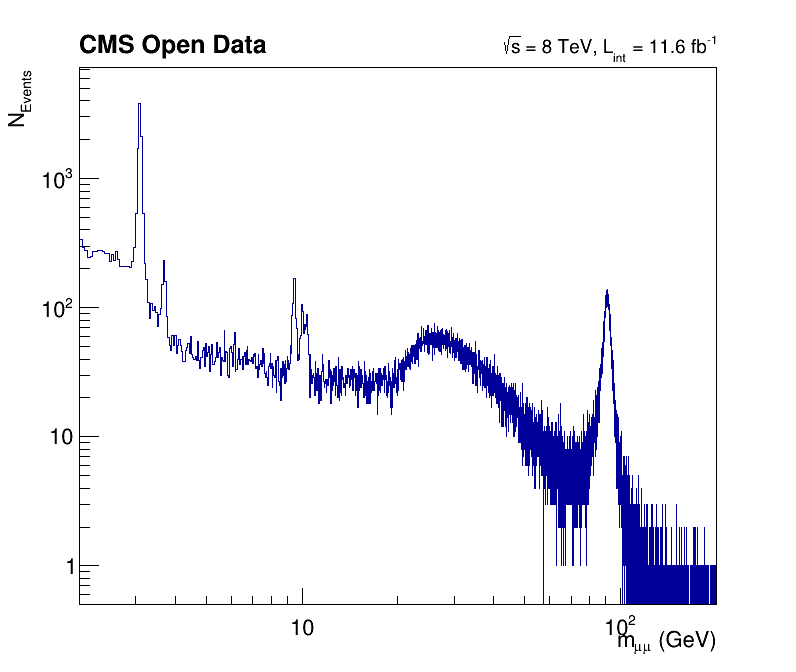

In [8]:
%jsroot on
c.Draw()

## Print the cutflow report

In [9]:
report.Print()

Events with exactly two muons: pass=131936     all=270077     -- eff=48.85 % cumulative eff=48.85 %
Muons with opposite charge: pass=100000     all=131936     -- eff=75.79 % cumulative eff=37.03 %
